In [5]:
import openml
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder #For encoding categorical variables
from sklearn.preprocessing import MinMaxScaler

# Download Dataset Using openml

In [7]:
dataset = openml.datasets.get_dataset("iris")
print(dataset.default_target_attribute)
print(dataset.description[:500])

class
**Author**: R.A. Fisher  

**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Iris) - 1936 - Donated by Michael Marshall  

**Please cite**:   



**Iris Plants Database**  

This is perhaps the best known database to be found in the pattern recognition literature.  Fisher's paper is a classic in the field and is referenced frequently to this day.  (See Duda & Hart, for example.)  The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One c


In [13]:
df, y, categorical_indicator, attribute_names = dataset.get_data(
    target=dataset.default_target_attribute, dataset_format="dataframe"
)
df["class"]=y
df

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [16]:
df["class"].values

['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', ..., 'Iris-virginica', 'Iris-virginica', 'Iris-virginica', 'Iris-virginica', 'Iris-virginica']
Length: 150
Categories (3, object): ['Iris-setosa' < 'Iris-versicolor' < 'Iris-virginica']

# Identify Data Types

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sepallength  150 non-null    float64 
 1   sepalwidth   150 non-null    float64 
 2   petallength  150 non-null    float64 
 3   petalwidth   150 non-null    float64 
 4   class        150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB


In [18]:
df.describe()

,sepallength,sepalwidth,petallength,petalwidth
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


# Transform categorical variable to numeric

In [19]:
le=LabelEncoder()
df[["class"]]=df[["class"]].apply(lambda col : le.fit_transform(col))
df

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [20]:
df["class"].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [21]:
class_types = ('Iris-setosa','Iris-versicolor','Iris-virginica')
class_df = pd.DataFrame(class_types, columns=['Class_Types'])


class_df['Class_No'] = le.fit_transform(class_df['Class_Types'])
class_df=class_df.set_index("Class_Types")
class_df

,Class_No
Class_Types,
Iris-setosa,0
Iris-versicolor,1
Iris-virginica,2


# Min-max normalise

In [27]:
x=df.iloc[:,:4].values

scaler = MinMaxScaler()
# fit using the train set
scaler.fit(x)

# transform the test test
x_scaled = scaler.transform(X)
x_scaled

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ],
       [0.30555556, 0.70833333, 0.08474576, 0.04166667],
       [0.13888889, 0.58333333, 0.10169492, 0.04166667],
       [0.13888889, 0.41666667, 0.06779661, 0.        ],
       [0.        , 0.41666667, 0.01694915, 0.        ],
       [0.41666667, 0.83333333, 0.03389831, 0.04166667],
       [0.38888889, 1.        , 0.08474576, 0.125     ],
       [0.30555556, 0.79166667, 0.05084746, 0.125     ],
       [0.22222222, 0.625     ,

# Joblib Code

In [28]:
import joblib

In [30]:
# param_grid ={"n_clusters":[] ,
#              "init":[] , 
#              "max_iter":[] , 
#              "n_init":[]}

In [31]:
x=df.iloc[:,:4].values
x

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

# KMean Clustering

In [33]:
from sklearn.cluster import KMeans
sum_of_square_distance = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    sum_of_square_distance.append(kmeans.inertia_)

In [42]:
import plotly.express as px
fig = px.line(sum_of_square_distance)
fig['layout'].update(title='The elbow method')
fig['layout']['xaxis'].update(title='Number of clusters')
fig['layout']['yaxis'].update(title='Sum of Square Distance')
fig.show()

In [44]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans=kmeans.fit_predict(x)
y_kmeans

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

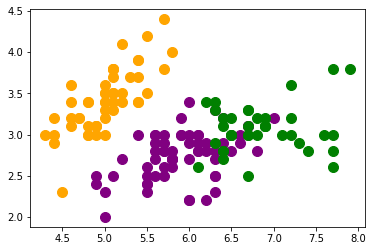

In [48]:
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'purple', label = 'Iris-setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'orange', label = 'Iris-versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')

# Agglomerative Clustering

In [49]:
from sklearn.cluster import AgglomerativeClustering